In [24]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve, mean_squared_error
from sklearn.metrics import classification_report, precision_score, recall_score, plot_precision_recall_curve

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# Содержание<a name="0"></a>

1. [Введение](#1)
2. [Решающие деревья](#2)
3. [Построение решающих деревьев](#3)
4. [Метрики качества регрессии. Практика](#4)
5. [Метрики качества классификации](#5)
6. [Практика для метрик классификации](#6)
7. [Underfitting и overfitting](#7)
8. [Underfitting и overfitting. Практика](#8)
9. [Дисбаланс выборки](#9)
10. [Дисбаланс выборки. Практика](#10)
11. [Визуализация процесса обучения](#11)

---

# Введение<a name="1"></a>

>### ПРИМЕР
>
>* Вы приходите в банк за кредитом, подаёте анкету со всеми необходимыми документами.
>* Сотрудник банка проверяет вашу анкету:
>    1. Если объём сбережений <= 200 тыс., то перейти к шагу 2, иначе — к шагу 3.
>    2. Если рабочий стаж больше года — дать кредит, иначе — не давать.
>    3. Если продолжительность займа < 30 месяцев — не давать кредит, иначе — к шагу 4.
>    4. ...  
>    
> Путём проверки по одному правилу за раз сотрудник банка определяет, стоит ли дать вам кредит.

Аналогичный способ принятия решения мы можем также изобразить визуально, для лучшего понимания. Например, для принятия решения о страховании того или иного автовладельца дерево решений может выглядеть следующим образом:

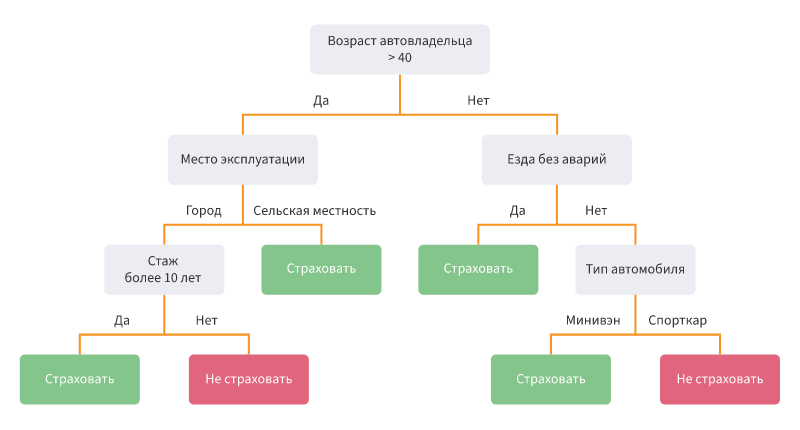

Схожим образом работает алгоритм машинного обучения <span style="color:green"><b>Решающее Дерево</b> <i>(Decision Tree)</i></span>.

>### ОПРЕДЕЛЕНИЕ
>
>Формально дерево решений — это связный ациклический граф. В нём можно выделить три типа вершин:  
>
>* Корневая вершина (*root node*) — откуда всё начинается.
>* Внутренние вершины (*intermediate nodes*).
>* Листья (*leafs*) — самые глубокие вершины дерева, в которых содержится «ответ».  
>
>Во внутренней или корневой вершине признак проверяется на некий логический критерий, по результатам которого мы движемся всё глубже по дереву.

Определенный бонус решающего дерева в том, что его легко интерпретировать, а также легко визуализировать ход принятия решения. Однако есть и ряд недостатков. В целом достоинства и недостатки данного метода следующие:

>### <span style="color:green">ДОСТОИНСТВА
>
>* <span style="color:green">Деревья требуют небольших усилий при подготовке данных (не требуется специфической предобработки).
>* <span style="color:green">Дерево решений не требует нормализации/масштабирования данных.
>* <span style="color:green">Наличие пропусков не оказывает существенного влияния на построение дерева.
>* <span style="color:green">Модель деревьев решений достаточно интуитивно понятна и легко объяснима даже людям, не разбирающимся в методе.

>### <span style="color:red">НЕДОСТАТКИ  
>
>* <span style="color:red">Требует затрат больших вычислительных мощностей (по сравнению с другими алгоритмами).
>* <span style="color:red">В силу дискретной структуры дерево не дифференцируется по параметрам — нельзя найти хотя бы локальный экстремум.
>* <span style="color:red">Небольшое изменение в данных может заметно повлиять на структуру дерева.
>* <span style="color:red">При работе с непрерывными числовыми признаками дерево делит их на категории, и теряет информацию.
>* <span style="color:red">Алгоритм дает плохие результаты, если дерево используется для решения задачи классификации при несбалансированных классах.

### ДЛЯ ЧЕГО ВООБЩЕ МОЖЕТ ПРИМЕНЯТЬСЯ РЕШАЮЩЕЕ ДЕРЕВО?

Может показаться, что решающее дерево является методом только для решения задачи классификации. Однако это не так. С помощью решающего дерева можно решить и <b><span style="color:green">задачу регрессии</span></b>. 

По сути задача регрессии с помощью дерева решений решается аналогично <b><span style="color:green">задаче классификации</span></b>, однако в итоге мы получаем не принадлежность к классу, а некоторое определенное число. Например, если мы не решаем, давать или не давать страховку, а определяем для каждого водителя определенный страховой процент в зависимости от его стажа и прочих характеристик:

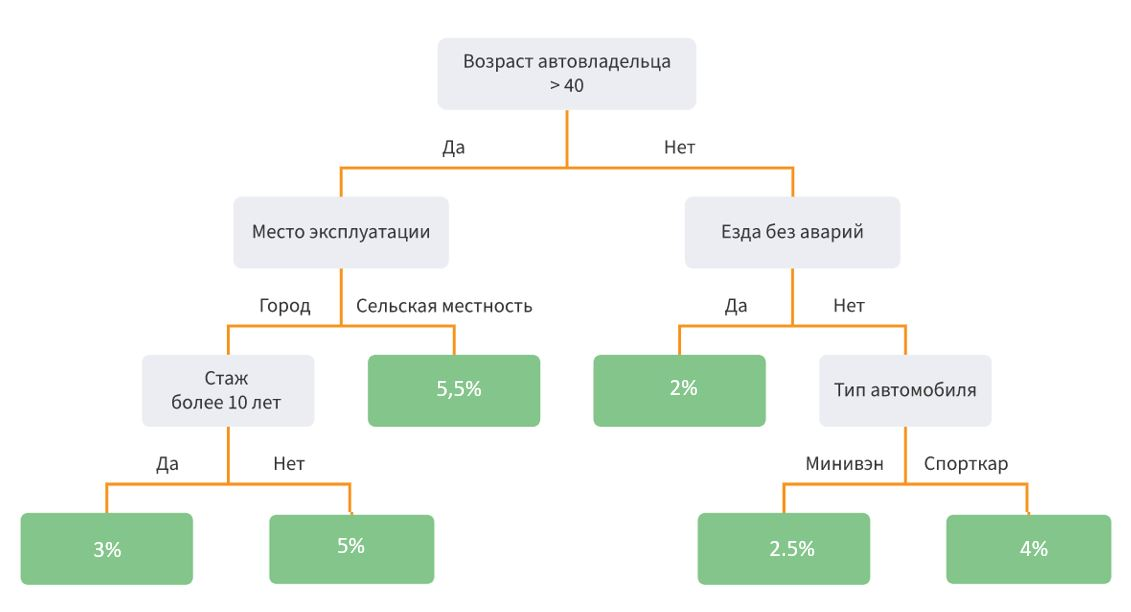

[К содержанию](#0)

---

# Решающие деревья<a name="2"></a>

Как вы уже могли заметить, этот алгоритм отличается от тех, что мы изучали ранее. Раньше мы изучали линейные модели. Перечислим <b><span style="color:green">особенности</span></b>, отличающие линейные модели от деревьев решений:  

* Линейные модели быстро учатся. В случае со среднеквадратичной ошибкой для вектора весов даже есть аналитическое решение. Также легко применять для линейных моделей градиентный спуск.
* При этом линейные модели могут восстанавливать только простые зависимости из-за ограниченного количества параметров.
* В то же время линейные модели можно использовать для восстановления нелинейных зависимостей за счёт перехода к спрямляющему пространству, что является довольно сложной операцией. 

><code>Примечание. С помощью некоторых методов можно перевести элементы для случая линейной неразделимости в новое линейно разделимое пространство. Именно такое пространство называют спрямляющим.

* Линейные модели не отражают особенности процесса принятия решений у людей. На самом деле, когда человек хочет понять ту или иную вещь, он будет задавать последовательность из простых вопросов, которые в итоге приведут его к какому-нибудь ответу.

### <span style="color:green">ОБОБЩЕННЫЙ ПСЕВДОКОД АЛГОРИТМА ПОСТРОЕНИЯ ДЕРЕВА

In [ ]:
function decision_tree(X, y):
    if stopping_criterion(X, y) == True:
        S = create_leaf_with_prediction(y)
    else:
        S = create_node()
        (X_1, y_1) .. (X_L, y_L) = best_split(X, y)
        for i in 1..L:
            C = decision_tree(X_i, y_i)
            connect_nodes(S, C)
    return S

Разберём, как строится дерево решений по заданной исходной выборке $X_0$ и ответах на ней $y_0$.  

Выше представлена <b><span style="color:green">рекурсивная функция</span></b>, которая при каждом новом вызове проверяет критерий остановки (*stopping_criterion*) для текущей подвыборки $(X, y)$.

Если критерий выполняется, то тогда функция возвращает $S$ — новый лист дерева с предсказанием (*create_leaf_with_prediction*), на основе правильных ответов $y$. Все объекты, которые попадут в этот лист, будут иметь это предсказание.

В ином случае строится внутренняя вершина, в которой затем будет определено правило разделения, по которому объекты могут попасть в одну из $L$ ветвей. Наилучшее разбиение (*best_split*) может определяться с помощью различных мер неопределённости (*impurity measures*), их мы обсудим позднее.

Подвыборки $(X_1, y_1)..(X_L, y_L)$ подаются на вход следующим вызовам нашей рекурсивной функции, чтобы в этих вызовах определить правила разбиения на более глубоких уровнях дерева. Эти вызовы вернут поддеревья $C$, которые затем можно объединить с построенным узлом $S$.

><code>Примечание. Узел дерева (например, **S**) задаёт целое поддерево идущих за ним узлов, если такие имеются, а не только сам этот узел.

### <span style="color:green">РЕШАЮЩИЕ ДЕРЕВЬЯ ДЛЯ ЗАДАЧИ КЛАССИФИКАЦИИ

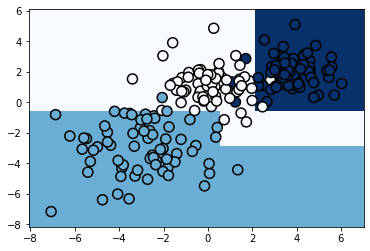

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

RANDOM_SEED = 139

train_data, train_labels = make_blobs(n_samples=200, centers=[(0,1),(-3,-3),(4,2)], 
                                      n_features=2, random_state=RANDOM_SEED,
                                      cluster_std=(1.2,1.5,1,))

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, 
                                  random_state=RANDOM_SEED)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='Blues')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='Blues', edgecolors='black', linewidth=1.5);

### Задачи

In [3]:
bill_data = pd.read_csv('bill_authentication.csv')

In [4]:
bill_data.head()

,Variance,Skewness,Curtosis,Entropy,Class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Обучите на предложенных данных решающее дерево. Целевой переменной здесь является переменная <code>Class</code>. Размер тестовой выборки возьмите за <code>0.2, random_state = 17</code> для разбиения и дерева. Максимальную глубину дерева примите за $3$, максимальное число признаков, по которым ищется лучшее разбиение в дереве — за $2$. Какое значение *f1-score* вы получили?

In [8]:
X = bill_data.drop(['Class'], axis=1)
y = bill_data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 17)

In [9]:
clf_tree = DecisionTreeClassifier(max_depth=3, max_features=2, random_state=17)

In [10]:
clf_tree.fit(X_train, y_train)

y_pred = clf_tree.predict(X_test)
F1 = f1_score(y_test, y_pred)

In [12]:
print(f'F1 Score = {round(F1, 3)}')

F1 Score = 0.866


Проклассифицируйте банкноту с вектором признаков <code>2.04378,-0.38422,1.437292,0.76421</code>. К какому классу она относится?

In [13]:
vector = [2.04378,-0.38422,1.437292,0.76421]
vector_pred = clf_tree.predict([vector])

In [16]:
print(f'Class = {vector_pred[0]}')

Class = 0


Здесь приведена <b><span style="color:green">визуализация</span></b> того, как одно решающее дерево разделяет выборку, состоящую из <b><span style="color:green">трёх классов</span></b>.  

Видно, что решающее дерево может очень неплохо отделить каждый класс от всех остальных. Разделяющая поверхность каждого класса кусочно-постоянная, и при этом каждая сторона поверхности параллельна оси координат, так как каждое условие сравнивает значение ровно одного признака с порогом.  

В то же время решающее дерево вполне может переобучиться: его можно сделать настолько глубоким, что каждый лист решающего дерева будет соответствовать ровно одному объекту обучающей выборки. В этом случае, если записать в каждом листе ответ соответствующего объекта, на обучающей выборке получается нулевая ошибка. Дерево получается явно <b><span style="color:green">переобученным</span></b>. Пример такого дерева:

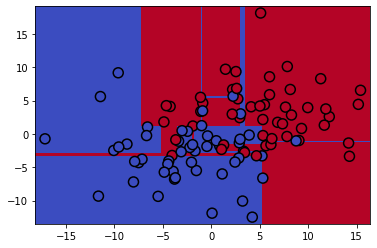

In [17]:
RANDOM_SEED = 139

train_data, train_labels = make_blobs(n_samples=100, centers=[(-3,-3),(4,2)], 
                                      n_features=2, random_state=RANDOM_SEED,
                                      cluster_std=(5,5))


clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, 
                                  random_state=RANDOM_SEED)

# training the tree
clf_tree.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='coolwarm')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);

### <span style="color:green">РЕШАЮЩИЕ ДЕРЕВЬЯ ДЛЯ ЗАДАЧИ РЕГРЕССИИ

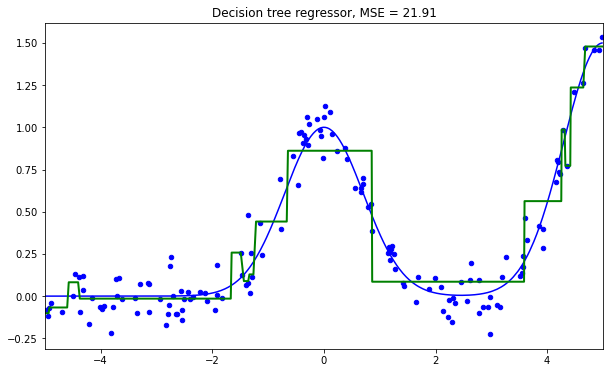

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

RANDOM_SEED = 139

n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 5) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 5) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_SEED)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

### <span style="color:green">БОРЬБА С ПЕРЕОБУЧЕНИЕМ (РЕГУЛЯРИЗАЦИЯ)

Приведём несколько возможных способов сделать алгоритм более обобщающим, т.е. менее заточенным под конкретную выборку:

* Задать порог по мере неопределённости: $I(S) \leq \theta$
* Задать порог по размеру узла: $\left |S \right | \leq n$
* Задать порог на глубину: $Depth(T)=d$
* Задать порог на размер потомков $\left | S_L \right |\leq n_1$ & $\left | S_R \right | \leq n_2$, здесь $S$ — это узел дерева, $T$ — дерево, $\left |S \right |$ — количество элементов в узле, $S_L, S_R$ — соответственно правый и левый потомок узла $S$.

### ЗАДАЧА О ПОТРЕБЛЕНИИ ТОПЛИВА

In [19]:
petrol_data = pd.read_csv('petrol_consumption.csv')
petrol_data.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [21]:
X = petrol_data.drop(['Petrol_Consumption'], axis=1)
y = petrol_data['Petrol_Consumption']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state = 42)

Обучите решающее дерево для регрессии на предложенных данных, размер тестовой выборки возьмите за <code>0.3, random_state = 42</code> для разбиения и дерева. Вычислите *RMSE*.

In [22]:
reg_tree = DecisionTreeRegressor(random_state=42)

In [23]:
reg_tree.fit(X_train, y_train)
y_pred = reg_tree.predict(X_test)

In [25]:
RMSE = mean_squared_error(y_test, y_pred)**0.5
print(f'RMSE = {round(RMSE, 2)}')

RMSE = 87.97


Какова глубина дерева?

In [26]:
print(f'Глубина дерева = {reg_tree.get_depth()}')

Глубина дерева = 11


[К содержанию](#0)

---

# Построение решающих деревьев<a name="3"></a>

[К содержанию](#0)

---

# Метрики качества регрессии. Практика<a name="4"></a>

## Метрики качества

### Loss function

Самой базовой метрикой качества алгоритма является функция ошибки, т.е. функция минимизируемого функционала. Например, в задаче регрессии это может быть **сумма квадратов разностей** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая представляется формулой:
$$
MSE=\frac{1}{n}\sum_{i=1}^{n}({Y_i-\hat{Y}_i})^2,
$$
где $n$ — количество примеров, $Y_i$ — истинные значения, $\hat{Y_i}$ — предсказанные моделью значения.

В задачах классификации часто применяется ошибка **перекрестная энтропия** ([Cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression)), которая в случае бинарной классификации (**binary cross-entropy**) выглядит следующим образом:
$$
-\frac{1}{n}\sum_{i=1}^{n}{\lbrack(Y_i*log(\hat{Y}_i) + (1-Y_i)*log(1-\hat{Y}_i)\rbrack}
$$

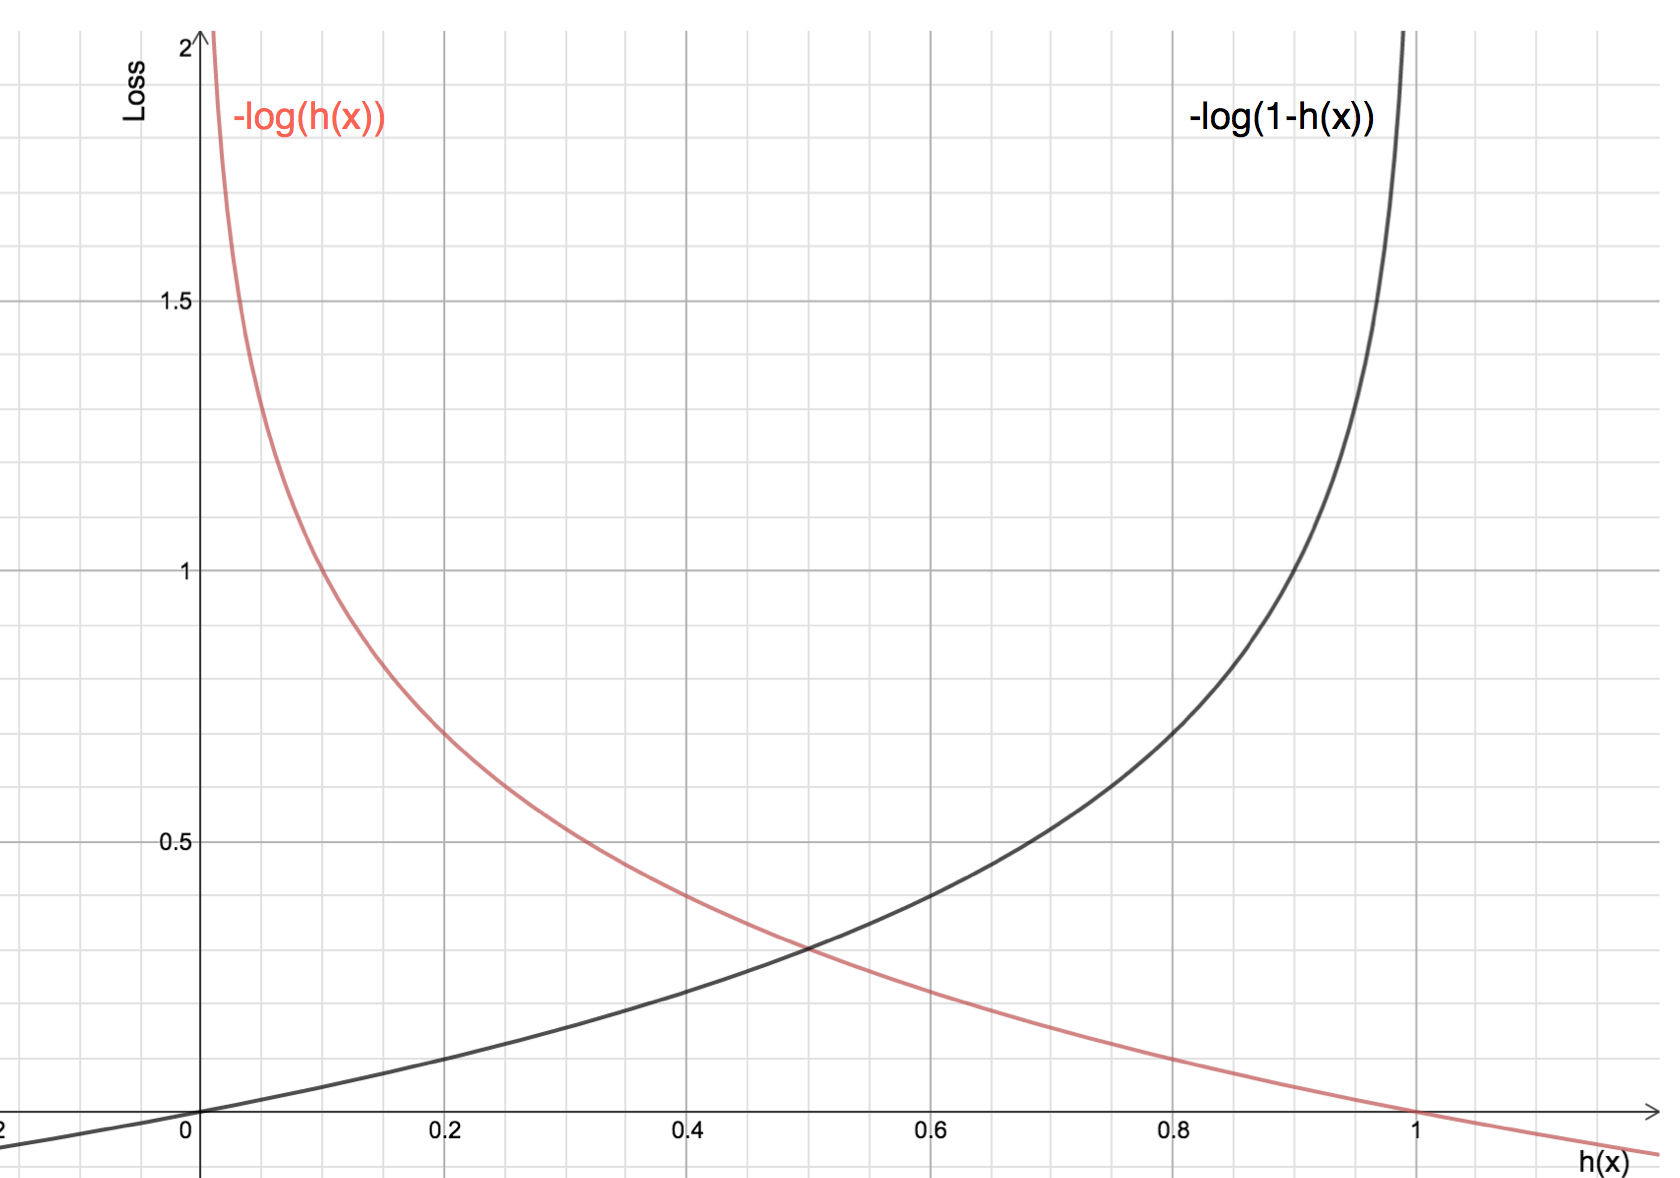

[Источник изображения](https://houxianxu.github.io/2015/04/23/logistic-softmax-regression/)

Для классификации на произвольное количество классов используется функция ошибки в общем виде:
$$
-\frac{1}{n}\sum_{i=1}^{n}{\sum_{c=1}^{C}{Y_i^c*log(\hat{Y}_i^c)}},
$$
где $C$ — количество классов в задаче.

Посчитаем значение ошибки для случайно предсказанных классов. Нашим алгоритмом будет монетка с тремя гранями, которая пытается угадать класс ириса.

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

iris_data = pd.read_csv('iris.data', 
                        names=['sepal_length', 'sepal_width', 
                               'petal_length', 'petal_width', 'class'])

In [40]:
# Функция, выбирающая один класс из заданного кол-ва классов
def monetka(n_classes=3):
    classes = np.arange(n_classes)
    predicted = np.random.choice(classes)
    
    return predicted

In [41]:
# Определить количество примеров, классов и сформировать словарь для конвертирования имени класса в порядковое число
n = iris_data.shape[0]
class_to_num = {cl: num for num, cl in enumerate(np.unique(iris_data['class']))}
n_classes = len(class_to_num)

In [42]:
# Истинные значения
y = np.array(iris_data['class'].apply(lambda cl: class_to_num[cl]))

In [43]:
# Предсказанные монеткой значения
y_pred = np.array([monetka(n_classes) for _ in range(n)])
y_hat = np.zeros((n, n_classes), dtype=np.float32)
for num in class_to_num.values():
    y_hat[:, num] = 1. * (y_pred == num)

In [44]:
from sklearn.metrics import log_loss

In [45]:
# Посчитаем значение ошибки
log_loss(y, y_hat)

24.177143478393553

Одно значение ошибки мало о чем говорит. Функции ошибки не всегда читаются напрямую, а имеют смысл при просмотре в сравнении: при хорошей сходимости алгоритма ошибка должна существенно падать после очередной итерации обучения.

Для более понятных человеку результатов рассмотрим класс популярных метрик, относящихся к бинарной классификации.

Для подсчета метрик возьмем искусственную задачу, где определим истинные классы следующим образом:

In [46]:
n = 100    # размер выборки
p = 0.1    # доля примеров класса 1

In [47]:
from scipy import stats

In [48]:
# Сгенерируем n примеров с долей единиц равной p
dist = stats.bernoulli(p)
y_true = dist.rvs(n)
print(y_true)

[1 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


### Accuracy

**Accuracy** (точность) — самая базовая метрика для определения точности алгоритма, которая подсчитывает количество правильно предсказанных объектов к общему числу объектов.

#### Введем следующие понятия для формального определения метрик:  
**True positives (TP)** — кол-во правильно предсказанных примеров положительного класса  
**True negatives (TN)** — кол-во правильно предсказанных примеров отрицательного класса  
**False positives (FP)** — кол-во неправильно предсказанных примеров положительного класса (ложных срабатываний)  
**False negatives (FN)** — кол-во неправильно предсказанных примеров отрицательного класса (ложных отрицаний)  
__Positives (P)__ - общее кол-во примеров положительного класса  
**Negatives (N)** - общее кол-во примеров отрицательного класса

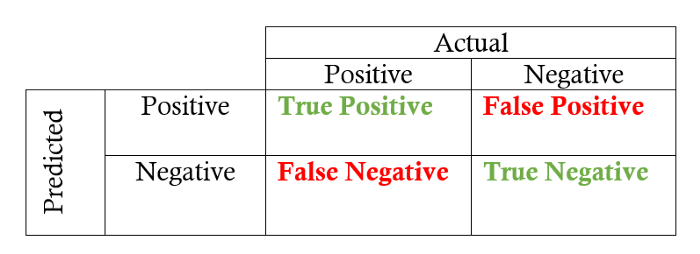

[Источник картинки](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

Тогда формально метрика accuracy выразится следующим образом:
$$
accuracy = \frac{TP+TN}{Positive+Negative}
$$

In [49]:
def calc_accuracy(y_true, y_pred):
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))

    acc = (TP + TN) / (P + N)
    
    return acc, TP, TN, P, N

Возьмем предсказания двугранной монетки для нашей выборки:

In [50]:
y_pred = np.array([monetka(2) for _ in range(n)])

Посчитаем значение accuracy:

In [51]:
acc, TP, TN, P, N = calc_accuracy(y_true, y_pred)
print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {}%'.format(TP, TN, P, N, acc * 100))

TP = 9
TN = 42
P = 15
N = 85
acc = 51.0%


То же самое можно сделать с помощью функции [accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) библиотеки scikit-learn:

In [52]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true, y_pred)
print('Accuracy from scikit-learn: {}%'.format(acc * 100))

Accuracy from scikit-learn: 51.0%


Наш алгоритм работает с точностью 50% (может отличаться от запуска к запуску). Совсем неплохо для случайной монетки. Но давайте попробуем улучшить результат. Мы же знаем, что наша выборка приблизительно на 90% состоит из примеров отрицательного класса. Тогда пусть наша монетка будет однобокой и всегда будет выдавать 0 в качестве ответа:

In [53]:
y_pred = np.zeros(n)

In [54]:
acc, TP, TN, P, N = calc_accuracy(y_true, y_pred)
print('TP = {}\nTN = {}\nP = {}\nN = {}\nacc = {}%'.format(TP, TN, P, N, acc * 100))

TP = 0
TN = 85
P = 15
N = 85
acc = 85.0%


90%! Монетка стала предсказывать еще лучше.  
На самом деле монетка предсказывает только один класс, абсолютно игнорируя второй. В этом и есть главная проблема метрики accuracy: если выборка содержит разное количество примеров каждого класса, то добиться высокой точности можно даже просто не предсказывая редкие классы.  
Для таких несбалансированных выборок accuracy не может являться ключевой метрикой. Далее мы рассмотрим метрики, с помощью которых можно избежать дизбаланса классов, такие как precision, recall и F1-score.

### precision и recall

**precision** — метрика, измеряющая, насколько много из принятых моделью положительных объектов в действительности являются положительными.  
**recall** — метрика, измеряющая, насколько много положительных объектов из всех положительных объектов модель выбрала.

$$
precision = \frac{TP}{TP+FP} \quad recall = \frac{TP}{TP+FN}
$$

Интересный факт про обе метрики заключается в том, что при возрастании одной общей тенденцией второй является падение. В некотором смысле они противоположны. Это отражает следующий пример графика:
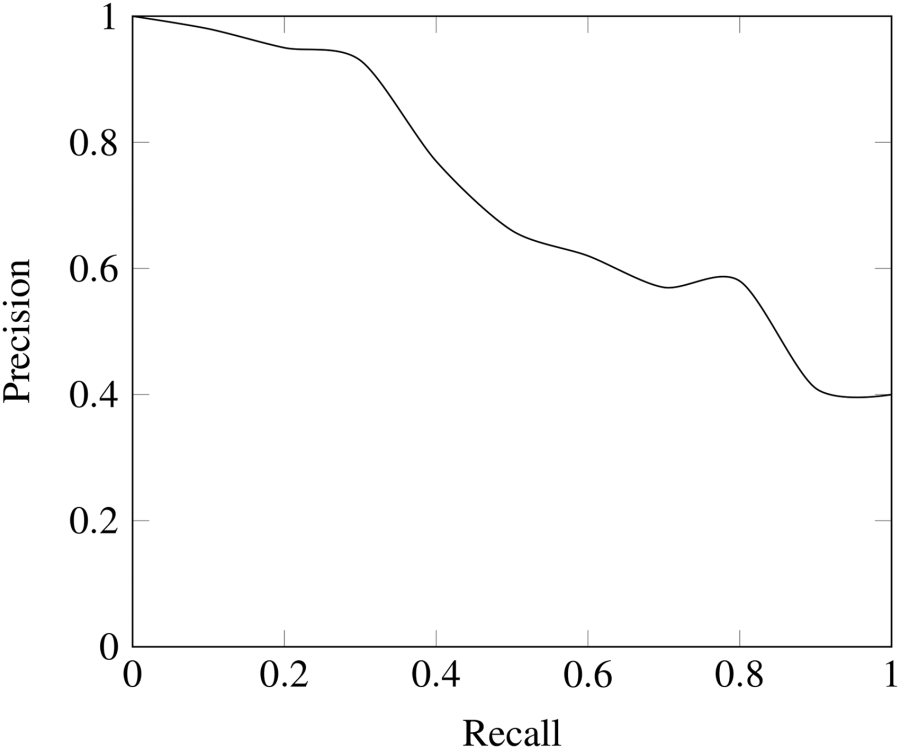 
[Источник картинки](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)

Посчитаем метрики precision и recall для нашей задачи с помощью методов [precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) и [recall_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) библиотеки scikit-learn:

In [55]:
from sklearn.metrics import precision_score, recall_score

In [56]:
precision = precision_score(y_true, 1 - y_pred)
recall = recall_score(y_true, 1 - y_pred)
print('precision: {:.2f}\nrecall: {:.2f}'.format(precision, recall))

precision: 0.15
recall: 1.00


Полученные значения метрик говорят, что алгоритм никогда не назначает объектам положительный класс. Тут мы его и поймали. А теперь подумайте, что бы случилось, если положительным классом было наличие раковой болезни человека — модель бы не нашла рак ни у одного пациента!

Вернемся к случаю, где модель выбирает положительный и отрицательный классы с равной вероятностью:

In [57]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print('precision: {:.2f}\nrecall: {:.2f}'.format(precision, recall))

precision: 0.00
recall: 0.00


precision в данном случае говорит, что из тех объектов, которые модель считает положительными, в действительности очень мало положительных. recall говорит, что модель хотя бы какой-то относительно неплохой процент положительных объектов все-таки находит. По двум числам трудно оценивать модель, поэтому были придуманы объединяющие метрики, такие как F1-score.

### F1-score

**F1-score** — метрика, объединяющая precision и recall, принимающая во внимание, что и та, и другая важны для задачи.

$$
F1\_score = \frac{2*precision*recall}{precision+recall}
$$

Вообще говоря, метрика F1-score является частным случаем метрики F-beta score, о которой вы можете прочитать [здесь](https://en.wikipedia.org/wiki/F1_score#Definition).

Посчитаем F1-score для нашей задачи с помощью метода [f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) библиотеки scikit-learn:

In [58]:
from sklearn.metrics import f1_score

In [59]:
f1 = f1_score(y_true, y_pred)
print('F1-score: {:.2f}'.format(f1))

F1-score: 0.00


Чем выше значение F1-score, тем лучше. Как видим, наш алгоритм работает неудовлетворительно.  
И это неудивительно, что неудовлетворительно.

### precision-recall curve

**precision-recall curve** показывает зависимость precision от recall, т.е. насколько точно алгоритм выбирает положительные объекты при изменении его чувствительности к положительному классу.

Посчитаем precision-recall curve, используя метод [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) библиотеки scikit-learn:

In [60]:
from sklearn.metrics import precision_recall_curve

In [61]:
precisions, recalls, _ = precision_recall_curve(y_true, y_pred)

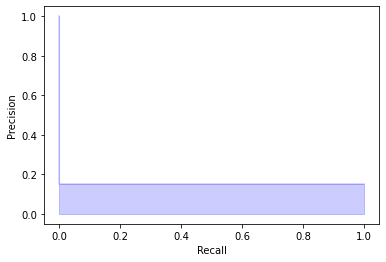

In [62]:
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='b')
plt.xlabel('Recall');
plt.ylabel('Precision');

Еще одной обобщающей характеристикой precision и recall является **average precision (AP)**, которая вычисляется как взвешенное среднее значений precision:
$$
AP = \sum_{n}{(R_n - R_{n-1})P_n},
$$
где $P_n$ и $R_n$ — precision и recall при $n$-ом отсечении. В некотором приближении значение AP есть значение иной характеристики, называемой **area under curve (AUC)** (площадь под кривой), являющейся важной метрикой при разработке классификаторов и детекторов.

Вычислим AP, используя метод [average_precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html) библиотеки scikit-learn:

In [63]:
from sklearn.metrics import average_precision_score

In [65]:
ap = average_precision_score(y_true, y_pred)
print('Average Precision (AP) = {:.2f}'.format(ap))

Average Precision (AP) = 0.15


### Confusion matrix

[confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) — матрица, в строках которой отображено число примеров, предсказанных в определенном классе, а в столбцах число примеров, которые в самом деле принадлежат каждому классу (и наоборот). С помощью confusion matrix можно удобно смотреть, в какую сторону отклоняются предсказания алгоритма при виде объектов определенного класса.

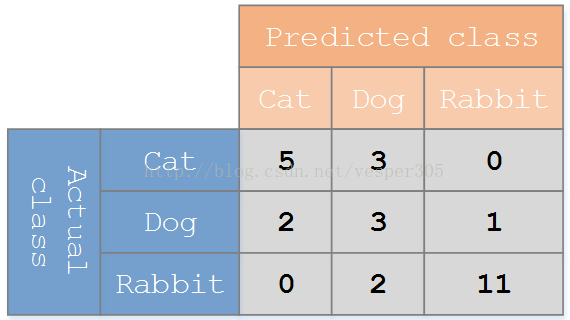

[Источник изображения](https://en.wikipedia.org/wiki/Confusion_matrix)

Вернемся к задаче с ирисами и посчитаем confusion matrix с помощью метода [confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) библиотеки scikit-learn:

In [66]:
from sklearn.metrics import confusion_matrix

In [67]:
# Определить количество примеров, классов и сформировать словарь для конвертирования имени класса в порядковое число
n = iris_data.shape[0]
class_to_num = {cl: num for num, cl in enumerate(np.unique(iris_data['class']))}
n_classes = len(class_to_num)

# Истинные значения
y_true = np.array(iris_data['class'].apply(lambda cl: class_to_num[cl]))

# Предсказанные монеткой значения
y_pred = np.array([monetka(n_classes) for _ in range(n)])

In [68]:
conf_mat = confusion_matrix(y_true, y_pred).T
print('Confusion matrix:\n{}'.format(conf_mat))

Confusion matrix:
[[19 18 21]
 [16 15 14]
 [15 17 15]]


Нарисуем confusion matrix так, чтобы было понятнее, что происходит:

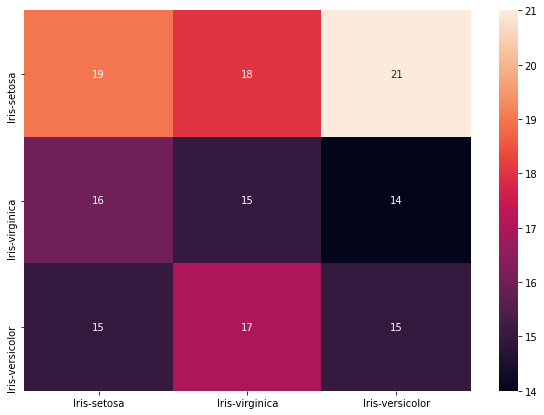

In [69]:
import seaborn as sn
class_names = ['Iris-setosa', 'Iris-virginica', 'Iris-versicolor']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True);

### Задания

Загрузите данные train.csv, оставьте в данных только признаки 'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', затем избавьтесь от пропусков. Целевой переменной будет 'balance_due', разделите данные на обучающую и тестовую выборки в соотношении 70% на 30% без перемешивания. Обучите линейную регрессию из *scikit-learn* и запишите в переменную result значение метрики *RMSE* на тестовой выборке.

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
vis_data = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)

In [87]:
vis_data = vis_data[['fine_amount', 
                     'state_fee', 
                     'late_fee', 
                     'discount_amount', 
                     'balance_due']]

In [88]:
vis_data = vis_data.dropna(axis=0)

In [89]:
X = vis_data.drop(['balance_due'], axis=1)
y = vis_data['balance_due']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle=False)

In [90]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [91]:
RMSE = mean_squared_error(y_test, y_pred, squared=False)
print (round(RMSE, 2))

132.08


[К содержанию](#0)

---

# Метрики качества классификации<a name="5"></a>

Рассмотрим, как можно оценить качество алгоритма классификации.

С частью метрик вы познакомились в предыдущих модулях, проговорим их снова, добавив важные нюансы, и обсудим новые.

Для того, чтобы понимать формульные записи метрик, необходимо вспомнить матрицу:

### Confusion matrix

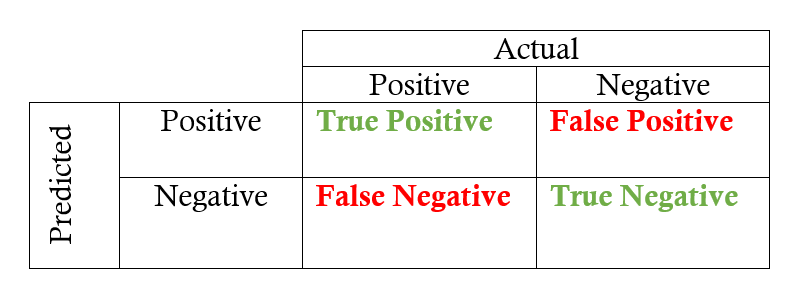

Будем обозначать _True Positive_ (верные положительные ответы) как TP, _False Positive_ (ошибочные положительные ответы) как FP, _False Negative_ (ошибочные отрицательные) как FN и _True Negative_ (верные отрицательные ответы) как TN. Теперь рассмотрим, как вычисляются основные метрики для классификации.

### Доля правильных ответов (Accuracy)

$$Accuracy = \frac{TN+TP}{TP+TN+FP+FN}$$

Проблема данной метрики в том, что она дает нерелевантные результаты на несбалансированных классах. Для того, чтобы нивелировать данную проблему, были созданы усовершенствованные метрики. Например, функционал качества Каппа Коэна. Его идея состоит в том, чтобы перенормировать значение точности (accuracy) с помощью точности, которую можно было получить случайно. Случайная точность $Accuracy_{chance}$ получается в случае случайной перестановки ответов:

$$\begin{equation}\text {k}=\frac{Accuracy - Accuracy_{chance}}{1-Accuracy_{chance}}\end{equation}$$

Также для случая дисбаланса классов существует аналог точности — __сбалансированная точность__:

$$\begin{equation}\mathrm{BA}=\frac{R_{1}+R_{0}}{2}=\frac{1}{2}\left(\frac{\mathrm{TP}}{\mathrm{TP}+\mathrm{FN}}+\frac{\mathrm{TN}}{\mathrm{TN}+\mathrm{FP}}\right)\end{equation}$$

### Precision и Recall

__Precision__ — метрика, измеряющая, насколько много из принятых моделью положительных объектов в действительности являются положительными.  
__Recall__ — метрика, измеряющая, насколько много положительных объектов из всех положительных объектов модель выбрала.

$$\begin{equation}\text {precision}=\frac{T P}{T P+F P}\end{equation}$$

$$\begin{equation}\text {recall}=\frac{T P}{T P+F N}\end{equation}$$

__F1-score__

*F1-score* — метрика, объединяющая *precision* и *recall*, принимающая во внимание, что обе важны для задачи. Частный случай *F-beta score*:

$$\begin{equation}F 1_{-} \text {score}=\frac{2 * \text {precision} * \text {recall}}{\text {precision }+\text {recall}}\end{equation}$$

$$\begin{equation}F_{\beta}=\left(1+\beta^{2}\right) \cdot \frac{\text { precision } \cdot \text { recall }}{\left(\beta^{2} \cdot \text { precision }\right)+\text { recall }}\end{equation}$$

Разумеется, все рассмотренные метрики реализованы в *Python*:

In [100]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import cohen_kappa_score

### Задачи

Используя библиотеку *sklearn*, найдите метод для подсчёта метрики $accuracy$. Создайте два одинаковых списка, состоящих из $100$ одинаковых чисел. Замените в одном списке одно число на любое другое, отправьте эти списки в метод для подсчёта $accuracy$. Что выдаст алгоритм на выходе? Ответ запишите с точностью до сотых, в качестве разделителя используйте точку.

In [97]:
y_true = [1]*100
y_pred = [1]*100
y_pred[45] = 0

In [98]:
Acc = accuracy_score(y_true,y_pred)
print(round(Acc, 2))

0.99


На этапе вычисления метрик вы получили результаты precision = 0.75 и recall = 0.6. Посчитайте значение метрики $f1$. Округлите до сотых и запишите результат.

In [107]:
prec = 0.75
rec = 0.6
f1 = (2*prec*rec)/(prec+rec)
print(round(f1, 2))

0.67


Допустим, у вас есть выборки y_true = $[0, 0, 1, 1, 1, 1, 0, 1]$ и y_pred = $[0, 1, 0, 0, 1, 1, 0, 1]$. Посчитайте значение метрики $f1$. Округлите до сотых и запишите результат.

In [102]:
y_true = [0, 0, 1, 1, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 0, 1]
f1 = f1_score(y_true, y_pred)
print(round(f1, 2))

0.67


Допустим, у вас есть выборки y_true = $[0, 0, 1, 0, 0, 1, 0]$ и y_pred = $[1, 1, 1, 0, 1, 1, 0]$. Посчитайте значение метрики $precision$. Округлите до сотых и запишите результат.

In [103]:
y_true = [0, 0, 1, 0, 0, 1, 0]
y_pred = [1, 1, 1, 0, 1, 1, 0]
prec = precision_score(y_true, y_pred)
print(round(prec, 2))

0.4


Допустим, у вас есть выборки y_true = $[0, 0, 1, 0, 0, 1, 0]$ и y_pred = $[1, 1, 1, 0, 1, 1, 0]$. Посчитайте значение метрики $recall$. Округлите до сотых и запишите результат.

In [104]:
y_true = [0, 0, 1, 0, 0, 1, 0]
y_pred = [1, 1, 1, 0, 1, 1, 0]
rec = recall_score(y_true, y_pred)
print(round(rec, 2))

1.0


[К содержанию](#0)

---

# Практика для метрик классификации<a name="6"></a>

Реализуем бинарную классификацию записей голосов (мужских и женских) на основе характеристик записей их разговоров.

В предложенном датасете есть ряд свойств, определенных по аудиозаписям:

* meanfreq: средняя частота голоса (в кГц)  
* sd: стандартное отклонение частоты голоса  
* median: медианная частота (в кГц)  
* Q25: значение в первом квартиле (в кГц)  
* Q75: значение в третьем квартиле (в кГц)  
* IQR: интерквартильный размах (в кГц)  
* skew: ассиметрия  
* kurt: эксцесс  
* sp.ent: спектральная энтропия  
* sfm: энтропия Винера
* mode: мода частоты
* centroid: частотный центроид
* meanfun: средняя основная частота, измеренная по акустическому сигналу
* minfun:  минимальная основная частота, измеренная по акустическому сигналу
* maxfun: максимальная основная частота, измеренная в акустическом сигнале
* meandom: среднее значение доминирующей частоты, измеренной по акустическому сигналу
* mindom: минимум доминирующей частоты, измеренной в акустическом сигнале
* maxdom: максимум доминирующей частоты, измеренной в акустическом сигнале
* dfrange: диапазон доминантных частот, измеренное на звуковой сигнал
* modindx: индекс модуляции голоса

Прежде, чем проводить анализ, можно с помощью визуализации оценить, есть ли различия в частотах голосов мужчин и женщин. Можем построить распределения, например, средних частот:

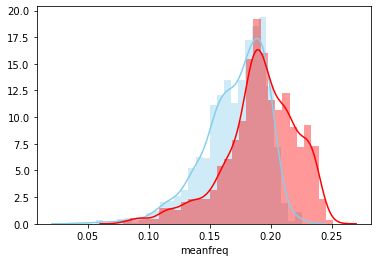

<span style="color:red">Красному</span> цвету соответствуют данные для женских голосов, <span style="color:blue">голубому</span> — для мужских. В целом можно отметить, что распределение частот женских голосов сдвинуто вправо относительно распределения мужских.

Итак, характеристики для голосов различаются, попробуем теперь реализовать классификацию на их основе.

### Задание 1
Попробуйте построить модель, предсказывающую пол обладателя записи голоса.

Для этого:

Разделите выборку на обучающую и тренировочную с параметрами test_size=0.3, random_state=42.

Нормализуйте признаки с помощью функции StandardScaler(). Учитывайте, что нормализация тестовой выборки производится по среднему и отклонению тренировочной, которую мы считаем репрезентативной относительно генеральной совокупности.

Обучите модель логистической регрессии на подготовленных данных.

Тестовые данные не должны влиять на параметры нормализации. Нужно использовать SCALER.TRANSFORM вместо SCALER.FIT_TRANSFORM, чтобы применять параметры нормализации, рассчитанные для тренировочных данных. Иначе данные в трейне и в тесте будут нормализованы по - разному.

In [110]:
voices = pd.read_csv("voiceDataSet.csv")

In [111]:
voices.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [112]:
voices['label'] = (voices['label'] != 'male').astype('int32')

In [114]:
voices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   int3

In [115]:
X = voices.drop(['label'], axis=1)
y = voices['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=42)

In [117]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [118]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

In [119]:
acc = accuracy_score(y_test,y_pred)
print(round(acc, 3))

0.973


### Кросс-валидация

Теперь познакомимся с новым алгоритмом классификации, а также снова потренируемся делить выборку и осуществлять кросс-валидацию. Кроме того, посмотрим, как можно оценить качество классификации для случая, когда наша классификация не бинарная, т.е. у нас несколько классов.

В этом кейсе мы попробуем определять типы стекла по его характеристикам.

In [120]:
glass = pd.read_csv("glass.csv")
glass.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Откроем данные и увидим, что в первых столбцах показатели содержания различных веществ в стекле, а в последнем (Type) — непосредственно тип стекла.

In [121]:
glass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Наша классификация мультиклассовая, поэтому мы должны посмотреть, сколько у нас классов. Если вы вообще ничего не знаете о задаче в плане количества классов, обязательно начинайте с этого, поскольку это повлияет на ход решения. Особенно важно понять, бинарная классификация или нет.

In [122]:
glass['Type'].nunique()

6

Итак, мы выяснили, сколько у нас классов и узнали, что в этот раз у нас будет не бинарная классификация. А значит, мы не сможем использовать некоторые метрики качества (например, $precision$ и $recall$).  

Приступим непосредственно к построению модели. На примере этой задачи мы узнаем новый алгоритм __kNN (метод ближайших соседей)__. Это один из простейших методов классификации. 

Его называют __ленивым классификатором__, потому что во время обучения модели он ничего не делает, просто считывает и сохраняет тренировочные данные. Сама классификация для него начинается тогда, когда ему дают тестовые данные. Тогда kNN проходит два базовых шага:

1. Сначала он ищет k ближайших размеченных точек данных – эти точки и называют __k ближайшими соседями__.

2. Затем, используя классы соседей, kNN решает, как лучше классифицировать новые данные. 

> #### Пример
>
>Предположим, что алгоритм хочет классифицировать вас по профессии. Он видит, что люди, рядом с которыми вы находитесь (родители, друзья), — врачи. Тогда он решает, что вы — тоже скорее всего врач. Грубо говоря, он основывается на принципе, что подобное находится рядом с подобным.

А что делать, если ближайшие соседи не принадлежат одному классу? Можно решать по принципу большинства или дать каждому соседу __вес__ (в зависимости от удаленности), с которым он будет вносить вклад в решение.

Например, попробуем классифицировать <b><span style="color:green">зеленый кружочек</span></b>. На этом примере мы видим, что выбор числа соседей (это настраиваемый параметр) очень важен.

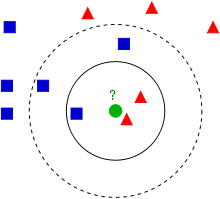

Если мы будем рассматривать трех соседей, то кружочек будет причислен к классу треугольников. А если пять соседей — к классу квадратов.

__Важно! Количество соседей должно быть нечетное во избежание спорной ситуации.__

Итак, мы разобрались с новым алгоритмом. Теперь воспользуемся k-fold валидацией на пяти разбиениях и обучим модель:

In [125]:
X = glass.drop(['Type'], axis=1)
y = glass['Type']

In [124]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
model=KNeighborsClassifier(n_neighbors=3)
kf = KFold(n_splits=5)
cross_val_score(model, X, y, cv=kf, scoring="accuracy")

array([0.44186047, 0.65116279, 0.3255814 , 0.34883721, 0.07142857])

Если мы посмотрим на результаты классификации, то увидим достаточно большой разброс значений точности, а также в целом невысокие значения.  

Это произошло в силу очень маленькой выборки в условиях большого количества классов (6 классов и около 200 наблюдений — крайне мало для получения высокого качества модели). Также плохой результат возможен по причине использования довольно простого алгоритма.

### Задание 2

Измените количество разбиений на 10. Вычислите среднее значение метрики $accuracy$ по 10 разбиениям и введите ниже, округлите до сотых.

In [128]:
kf = KFold(n_splits=10)
acc_mean = cross_val_score(model, X, y, cv=kf, scoring="accuracy").mean()
print(round(acc_mean, 2))

0.53


### Задание 3

В следующей задаче мы будем диагностировать болезни сердца по различным медицинским параметрам пациентов.

In [130]:
heart = pd.read_csv("heart_fin1.csv", sep=';')
heart.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,target
0,63,1,3,145,233,0,150,0,2.3,1
1,37,1,2,130,250,1,187,0,3.5,1
2,41,0,1,130,204,0,172,0,1.4,1
3,56,1,1,120,236,1,178,0,0.8,1
4,57,0,0,120,354,1,163,1,0.6,1


In [136]:
heart.shape[0]

303

Избавьтесь от выбросов, чтобы они не ухудшили качество нашей модели. Для того, чтобы избавиться от выбросов, уберите все данные, значения признаков которых отстают от первого или третьего квартиля более, чем на 1.5 межквартильного размаха.

In [139]:
def iqr_filter(col):
    df = heart
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    IQR = perc75 - perc25
    l_iqr = perc25 - 1.5*IQR
    r_iqr = perc75 + 1.5*IQR

    return df.loc[df[col].between(l_iqr, r_iqr)]

In [140]:
for col in heart.drop(['target'], axis=1).columns:
    heart = iqr_filter(col)

Сколько наблюдений осталось после удаления выбросов?

In [141]:
heart.shape[0]

284

Теперь разбейте выборку на тестовую и обучающую с параметрами test_size=0.15, random_state=5.

Обучите модели логистической регрессии ( c параметром max_iter=1000) и KNN (с количеством соседей, равным 3) на этих данных. Вычислите метрики качества.

У какой модели выше значение ROC AUC?

In [181]:
X = heart.drop(['target'], axis=1)
y = heart['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=5)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
y_pred_proba = log.predict_proba(X_test)
y_pred_proba = y_pred_proba[:, 1]

In [182]:
from sklearn.metrics import roc_auc_score
log_roc_auc = roc_auc_score(y_test,y_pred_proba)
print(round(log_roc_auc,2))

0.82


In [184]:
X = heart.drop(['target'], axis=1)
y = heart['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, random_state=5)
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred_proba = knn.predict_proba(X_test)
y_pred_proba = y_pred_proba[:, 1]
knn_roc_auc = roc_auc_score(y_test,y_pred_proba)
print(round(knn_roc_auc,2))

0.65


[К содержанию](#0)

---

# Underfitting и overfitting<a name="7"></a>

<b><span style="color:green">Переобучение (overfitting)</span></b> — проблема, при которой алгоритм чувствителен к незначительным колебаниям в данных в процессе обучения. Из-за этого алгоритм выучивает обучающий набор данных.

#### Как избавиться от переобучения
* Отложенная выборка (hold-out).
* k-fold валидация или leave-one-out валидация.
* Уменьшение сложности модели.
* Регуляризация.
* Добавление данных.

<b><span style="color:green">Недообучение (underfitting)</span></b> — проблема, при которой алгоритм недостаточно хорошо изучил данные и пропускает важные зависимости между признаками. В случае недообучения мы даже на обучающих данных не можем достичь приемлемых оценок для модели.

<b><span style="color:green">Почему может возникать недообучение?</span></b>

* Неправильно подобранный алгоритм обучения;
* Неадекватная функция ошибки;
* Не настроены или неправильно настроены гиперпараметры;
* Недостаточно данных для обучения. Зачастую, если увеличить обучающую выборку, то модель, которая раньше недообучалась, избавится от этой проблемы.

#### Как избавиться от недообучения?
* Усложнение модели.
* Ослабевание параметров регуляризации.

Чтобы лучше разобраться и лучше понять смысл переобучения и недообучения, рассмотрим иллюстративно на известных нам методах.

__Начнем с линейной регрессии:__

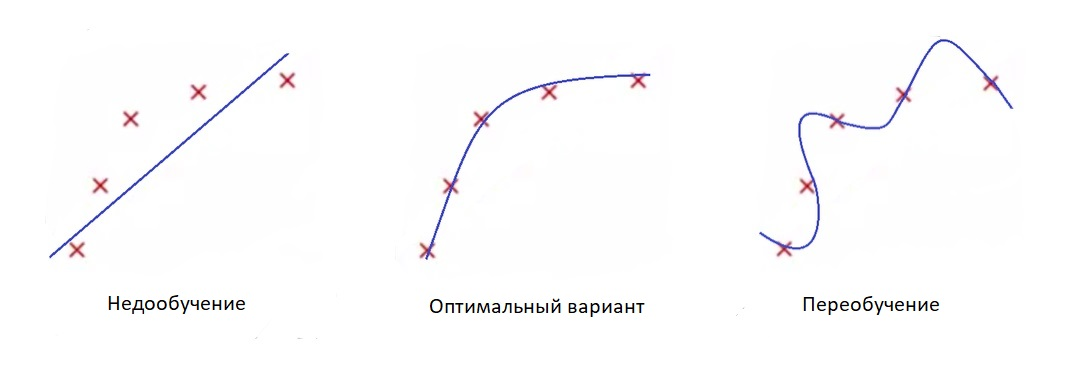

На данной картинке <span style="color:red">красными</span> крестиками обозначены исходные данные, а <span style="color:blue">синие</span> линии — аппроксимация исходных данных (предсказание).

На левом рисунке мы можем видеть, что простая линейная функция плоха для этих данных: там явно <b><span style="color:green">нелинейная зависимость</span></b>. Поэтому модель будет не очень качественной.

На средней картинке <b><span style="color:green">оптимальный</span></b> для нас вариант: функция не идеально подгоняется под все данные, но хорошо описывает закономерность.

А на правой картинке можно наблюдать слишком сильную подгонку под обучающие данные, что приведет к <b><span style="color:green">низкой прогностической способности</span></b> на новых данных.

Теперь рассмотрим иллюстрацию недообучения и переобучения __в случае классификации__:

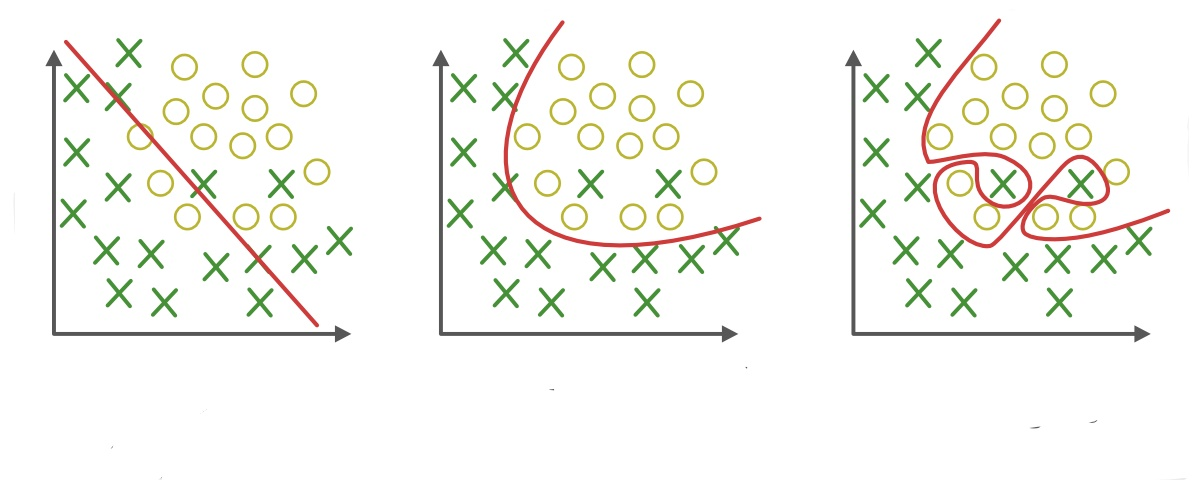

На левой картинке мы можем видеть <b><span style="color:green">плохую</span></b> классификацию. Модель слишком проста и некачественно разделяет  объекты по классам.

На центральной картинке практически <b><span style="color:green">идеальная</span></b> ситуация: выбрана более сложная модель, которая хорошо разделяет классы.

А вот на правой картинке — явный пример <b><span style="color:green">переобучения</span></b>: выбрана очень сложная модель, которая максимально подогнана под обучающие данные, однако на новых данных она скорее всего будет сильно ошибаться.

[К содержанию](#0)

---

# Underfitting и overfitting. Практика<a name="8"></a>

### Обобщающая способность

Рассмотрим пример классификации двух видов бабочек по двум параметрам - цвету и размаху крыльев. На первой картинке показаны исходные данные. Вы можете представить некоторую кривую, которая идеально разделяет эти два класса. Но после добавления новых точек окажется, что наша модель неспособна уловить зависимости в новых данных и допустит много ошибок. Здесь старые точки обведены в белый контур.

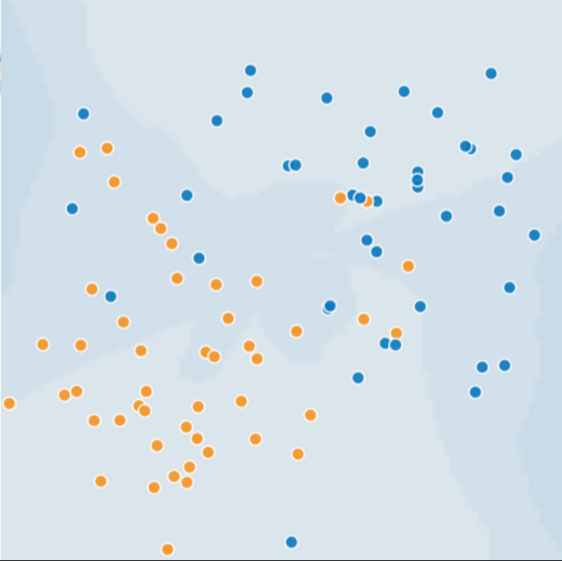
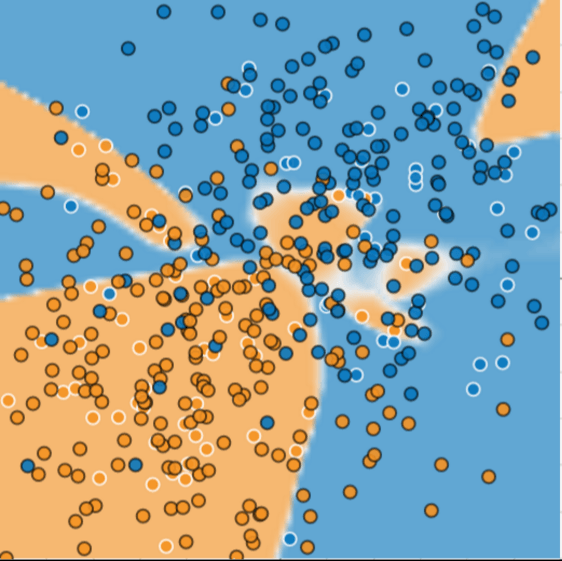

[Источник изображений](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting)

Важной характеристикой алгоритма машинного обучения является его **обобщающая способность** — способность использовать знания, полученные при обучении, на новых данных. Обобщающая способность часто страдает из-за двух основных проблем машинного обучения: overfitting (переобучение) и underfitting.  

Эти две проблемы зависят друг от друга, поэтому для их решения нужно решать так называемую дилемму **Bias-variance tradeoff**. Разберем обе эти проблемы и методы борьбы с ними.

### [Bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)

**Переобучение (overfitting)** — проблема, при которой алгоритм чувствителен к незначительным колебаниям в данных в процессе обучения, в следствие чего алгоритм "выучивает" слишком сложную зависимость в данных, которая на самом деле должна быть проще. Другое определение проблемы — **high variance (высокая вариативность)**. Более формальное определение можно получить из области статистики: [Variance (дисперсия случайной величины)](https://en.wikipedia.org/wiki/Variance).

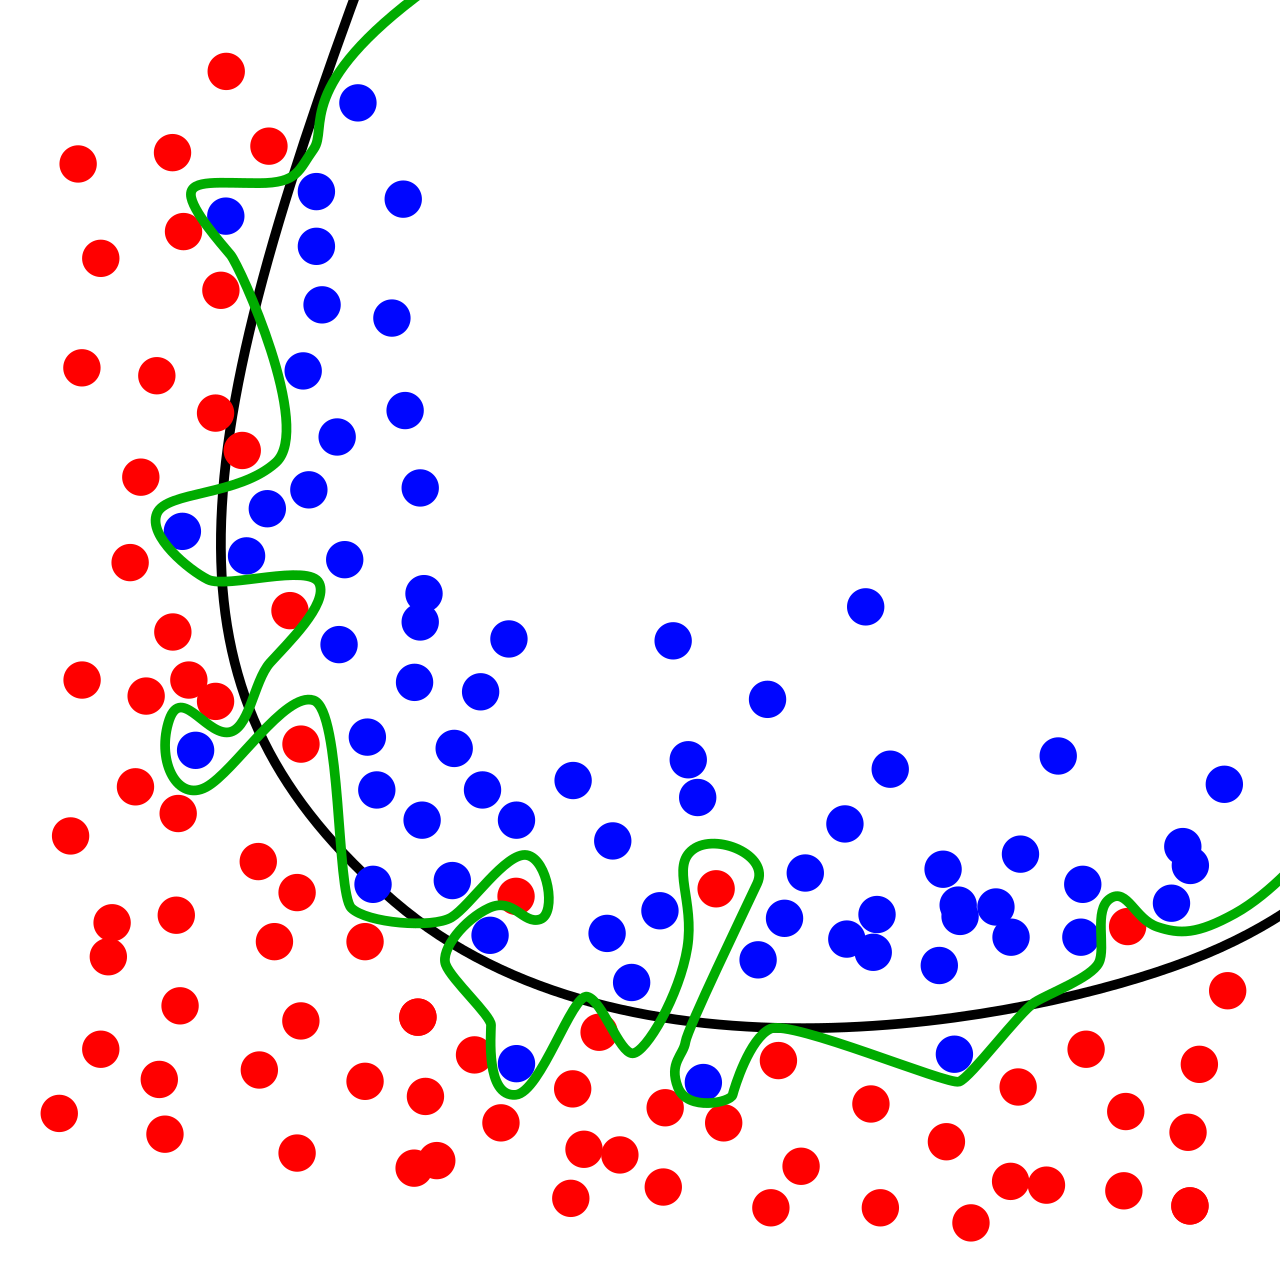

[Источник изображения](https://en.wikipedia.org/wiki/Overfitting)

**Underfitting** — проблема, при которой алгоритм недостаточно хорошо "изучил" данные и пропускает важные зависимости между признаками. Еще одно название проблемы —  **high bias (высокое смещение)**. Более формальное определение можно найти в статистике: [Bias of an estimator (Несмещенная оценка)](https://en.wikipedia.org/wiki/Bias_of_an_estimator)

In [186]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

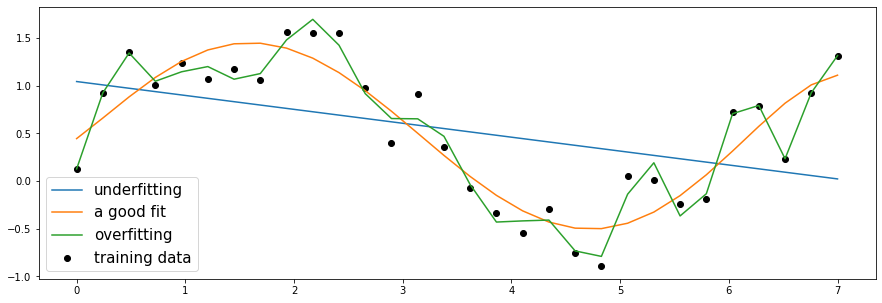

In [187]:
n_points = 30
x = np.linspace(0., 7., n_points)
y = np.sin(x) + np.random.rand(n_points)

plt.figure(figsize=(15, 5))
plt.scatter(x, y, color='k', label='training data')

for degree, label in zip([1, 5, 30], ['underfitting', 'a good fit', 'overfitting']):
    polynomial_coef = np.polyfit(x, y, deg=degree)
    inter_poly = np.polynomial.Polynomial(polynomial_coef[::-1])
    plt.plot(x, inter_poly(x), label=label)
plt.legend(fontsize=15)

### Как обнаружить переобучение

Переобучение является наиболее популярной проблемой, поэтому ее необходимо уметь обнаруживать моментально. При переобучении кривая значения функции ошибки на тренировочных данных показывает значительное убывание ошибки, в то время как на валидационной выборке значение ошибки меняется слабо, а иногда и вовсе деградирует.

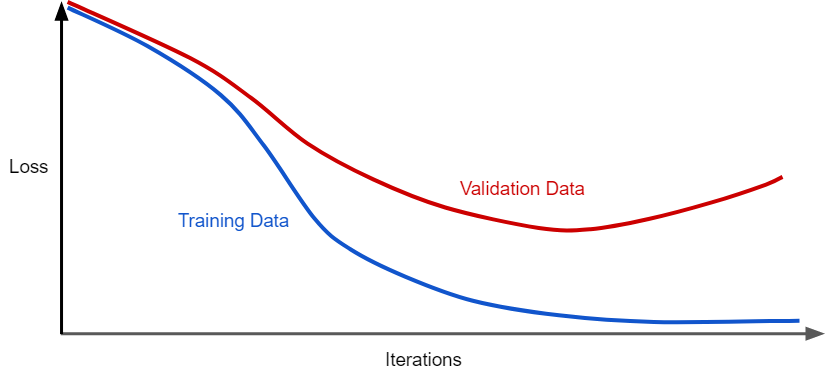  
[Источник изображения](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization)

### Как избавиться от переобучения

Существует несколько путей ограничить переобучение, с некотороми из них мы уже познакомились:
1. Отложенная выборка (hold-out)
2. k-fold валидация (или leave-one-out валидация)
3. Уменьшение сложности модели
4. Добавление данных
5. Регуляризация

_**Отложенная выборка**_ является отличным средством проверять точность алгоритма на этапе валидации, но позволить выделить такую выборку мы можем только в случае, если обладаем достаточным объемом данных.

В случае, если данных мало, на помощь приходит _**k-fold валидация**_ или валидация с одним отложенным примером (leave-one-out). Минусы этого подхода в том, что приходится оценивать модель, используя результаты с разных подмножеств валидационных данных, поэтому не всегда очевидно, какая модель является лучшей.

_**Уменьшение сложности**_ модели является основным способом борьбы с переобучением, т.к. по сути завышенная сложность модели и является его природой. В нашем примере полином степени 30 является сложной моделью, поэтому логично заключить, что нужно уменьшить степень интерполирующего полинома.

_**Увеличение объема обучающей выборки**_ также помогает избавиться от переобучения. Представьте, как при добавлении таких же зашумленных черных точек на график выше зеленая кривая будет чаще "промахиваться" по ним и постепенно сходиться к оранжевой линии, говоря о хорошей найденной зависимости.

Еще один важный способ борьбы с переобучением — _**регуляризация**_, которая заключается в добавлении штрафа модели в случаях, когда она отклоняется от каких-то норм. 

### Как избавиться от underfitting

Для решения проблемы underfitting можно инвертировать некоторые правила для избегания переобучения, поскольку эти две проблемы взаимозависимы. Итак, методы борьбы следующие:
1. Усложнение модели
1. Ослабевание параметров регуляризации

_**Усложнение модели**_ в данном случае поможет, т.к. простая модель может плохо описывать сложные закономерности. Примером усложнения может быть добавление новых признаков в данные, увеличение степени полинома, добавление новых слоев в нейронную сеть и др.

_**Ослабевание параметров регуляризации**_ есть не что иное как уменьшение размера штрафа на модель в случае ее отклонения от некоторых норм. Настройка параметров регуляризации будет также рассмотрена далее в курсе.

### Пример обучения

Здесь мы рассмотрим пример обучения дерева решений. В качестве датасета возьмем известный датасет [A Titanic Probability](http://web.stanford.edu/class/archive/cs/cs109/cs109.1166/problem12.html)

In [188]:
from sklearn.tree import DecisionTreeClassifier

In [189]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [190]:
# Заменить категориальный признак "Sex" на два признака "female" и "male" с бинарными значениями
sex_dummies = pd.get_dummies(titanic['Sex'])
titanic = titanic.drop('Sex', axis=1).join(sex_dummies)
# Отбросить имя человека из выборки
titanic = titanic.drop('Name', axis=1)
# Отделим target от признаков
X, y = titanic.iloc[:, 1:], titanic.iloc[:, 0]

#### Валидация на hold-out выборке

In [191]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, test_size=0.2, shuffle=True, random_state=123)

In [192]:
clf = DecisionTreeClassifier(random_state=456)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=456)

In [193]:
from sklearn.metrics import f1_score
y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

[train] F1-score = 0.98


In [194]:
y_pred = clf.predict(X_valid)
f1_val = f1_score(y_valid, y_pred)
print('[valid] F1-score = {:.2f}'.format(f1_val))

[valid] F1-score = 0.71


Как видим, точность при валидации значительно ниже точности при обучении. Проверим это дополнительно с помощью кросс-валидации:

#### Кросс-валидация

In [195]:
from sklearn.model_selection import cross_validate

In [196]:
clf = DecisionTreeClassifier(random_state=456)
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)

In [197]:
def plot_cv_metrics(cv_metrics):
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_train, std_f1_train))
    print('[valid] F1-score = {:.2f} +/- {:.2f}'.format(avg_f1_valid, std_f1_valid))
    
    plt.figure(figsize=(15, 5))

    plt.plot(cv_metrics['train_score'], label='train', marker='.')
    plt.plot(cv_metrics['test_score'], label='valid', marker='.')

    plt.ylim([0., 1.]);
    plt.xlabel('CV iteration', fontsize=15)
    plt.ylabel('F1-score', fontsize=15)
    plt.legend(fontsize=15)

[train] F1-score = 0.98 +/- 0.00
[valid] F1-score = 0.78 +/- 0.04


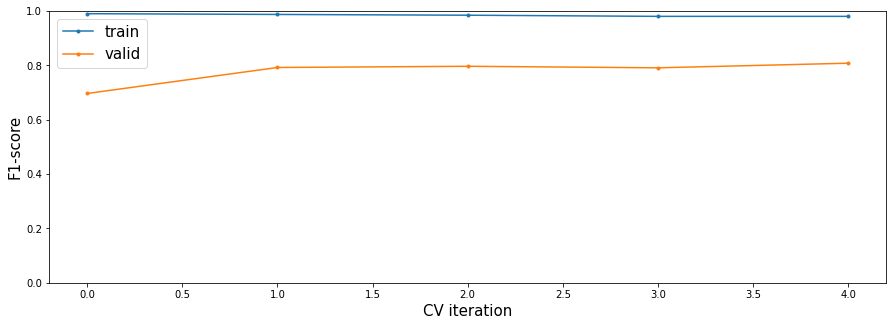

In [198]:
plot_cv_metrics(cv_metrics)

Гипотеза о переобучении подтвердилась. Попробуем избавиться от него, упростив модель — в данном случае ограничим глубину дерева:

[train] F1-score = 0.86 +/- 0.01
[valid] F1-score = 0.83 +/- 0.02


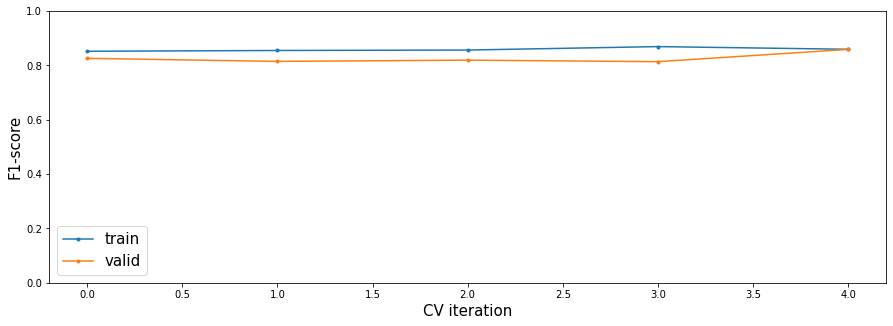

In [199]:
clf = DecisionTreeClassifier(max_depth=5, random_state=456)
cv_metrics = cross_validate(clf, X, y, cv=5, scoring='f1_micro', return_train_score=True)
plot_cv_metrics(cv_metrics)

Итак, метрики при обучении и валидации практически сравнялись, к тому же на валидации значение точности стало выше. Теперь возникает законный вопрос — а можно ли улучшить точность предсказаний? Вполне вероятно, что в данном случае присутствует проблема underfitting. Для ее решения можно заняться созданием новых признаков.

### Задачи

Загрузите данные train.csv, оставьте в данных только признаки 'fine_amount', 'state_fee', 'late_fee', 'discount_amount', 'balance_due', 'compliance', затем избавьтесь от пропусков.

Целевой переменной будет 'compliance', разделите данные на обучающую и тестовую выборки в соотношении 70%/30% без перемешивания.

Обучите DecisionTreeClassifier из scikit-learn с параметром random_state=23. Посчитайте значения метрики $F1$ на тренировочной выборке и на тестовой выборке. Вычтите из значения метрики на тренировочной выборки значение метрики на тестовой выборке и запишите результат в переменную result.

In [200]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
vis_data = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)
vis_data = vis_data[['fine_amount', 
                     'state_fee', 
                     'late_fee', 
                     'discount_amount', 
                     'balance_due', 
                     'compliance']]
vis_data = vis_data.dropna(axis=0)
X = vis_data.drop(['compliance'], axis=1)
y = vis_data['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle=False)
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=23)

In [203]:
y_pred = clf.predict(X_train)
f1_train = f1_score(y_train, y_pred)
print('[train] F1-score = {:.2f}'.format(f1_train))

[train] F1-score = 0.66


In [222]:
y_pred = clf.predict(X_test)
f1_test = f1_score(y_test, y_pred)
print('[test] F1-score = {:.2f}'.format(f1_test))

[test] F1-score = 0.58


In [205]:
result = f1_train - f1_test

[К содержанию](#0)

---

# Дисбаланс выборки<a name="9"></a>

<b><span style="color:green">Несбалансированная выборка (imbalanced dataset)</span></b> — выборка, в которой примеров каких-то классов намного больше, чем других. В случае регрессии <b><span style="color:green">дисбалансом выборки</span></b> будет ситуация, при которой распределение целевых значений будет сильно отличаться от равномерного.

<b><span style="color:green">Что происходит при дисбалансе классов:</span></b>

* У алгоритма появляется склонность к более популярным классам/значениям.

* Нельзя использовать метрики, не учитывающие веса классов, пример — accuracy.

<b><span style="color:green">Что делать:</span></b>

* Изменить целевую <b><span style="color:green">метрику</span></b> — в задачах классификации precision, recall, F1-score будут корректнее описывать алгоритм, чем accuracy.

* Изменить <b><span style="color:green">выборку</span></b> данных:
    <b><span style="color:green">oversampling</span></b> — увеличение количества объектов классов-меньшинств.
    <b><span style="color:green">undersampling</span></b> — сокращение количества объектов превалирующих классов.

* Добавить <b><span style="color:green">штраф</span></b> в оптимизационный функционал, прямо пропорциональный количеству объектов каждого класса (веса классов).

* Возможно, есть смысл перейти к задачам <b><span style="color:green">Anomaly detection</span></b> (поиск выбросов, шума и исключений)

[К содержанию](#0)

---

# Дисбаланс выборки. Практика<a name="10"></a>

**Несбалансированная выборка (imbalanced dataset)** — выборка, в которой количество примеров каких-то классов сильно превалирует над количеством примеров других классов. Это определение также можно расширить на другие типы задач. Например, в задаче регрессии дисбалансом выборки будет ситуация, при которой распределение целевых значений будет сильно отличаться от равномерного.

### Когда считать выборку несбалансированной?

In [206]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [207]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


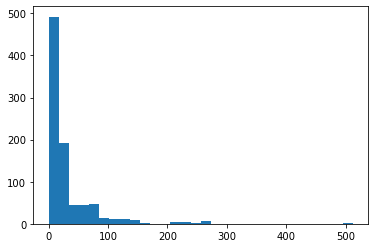

In [208]:
plt.hist(titanic['Fare'], bins=30);

<AxesSubplot:xlabel='Survived', ylabel='count'>

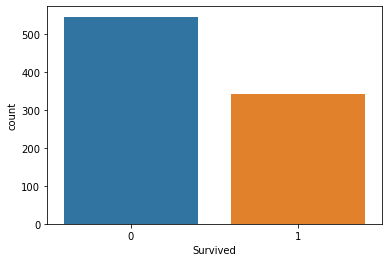

In [209]:
sns.countplot(x='Survived', data=titanic)

Нет точного определения, когда считать выборку несбалансированной. Неформально считается, что выборка несбалансированна, когда отношение количества преобладающего и минорного классов составляет 10:1.

### Последствия дисбаланса данных

Что происходит при дисбалансе классов:
1. У алгоритма появляется склонность к более популярным классам/значениям.
1. Невозможность использования метрик, не учитывающих веса классов (базовая метрика accuracy, изученная выше, не может быть использована).

### Решение проблемы

1. Изменить целевую метрику — в задачах классификации confusion matrix, precision, recall, F1-score, ROC-кривые будут намного корректнее описывать алгоритм, чем accuracy.
1. Изменить выборку данных: 1) oversampling — увеличение кол-ва объектов классов-меньшинств; 2) undersampling — сокращение кол-ва объектов превалирующих классов.
1. Добавить штраф в оптимизационный функционал, прямо пропорциональный кол-ву объектов каждого класса (веса классов).
1. Возможно, есть смысл перейти к задачам [Anomaly detection](https://en.wikipedia.org/wiki/Anomaly_detection) и [Change detection](https://en.wikipedia.org/wiki/Change_detection).

Во 2-м способе решение проблемы oversampling может быть выполнено как простым дублированием примеров меньшего класса, так и и более сложной техникой, называемой "аугментацией выборки".

**Аугментация выборки (data augmentation)** — процесс генерации примеров из исходных путем их модификации. Примерами аугментации данных могут служить: повороты, масштабирование изображений, применение фильтров; для текста может быть незначительно изменен контекст и изменено склонение/спряжение слов.

Еще одна техника, которая может быть использована для oversampling это **обогащение данных**. При использовании этой техники данные находятся во внешних дополнительных источниках. Например, если банк решает свою скоринговую задачу, он может также расширить свой набор данных данными другого банка при их наличии.

### Задания

Загрузите данные [train.csv](https://drive.google.com/open?id=1wbB8sqdz667_SUDISF57qSaSAUhtwlmP), оставьте в данных только признаки <code>'fine_amount'</code>, <code>'state_fee'</code>, <code>'late_fee'</code>, <code>'discount_amount'</code>, <code>'balance_due'</code>, <code>'compliance'</code>, затем избавьтесь от пропусков.

Обучим модель на несбалансированных данных. Целевой переменной будет <code>'compliance'</code>, разделите данные на обучающую и тестовую выборки в соотношении 70%/30% без перемешивания.

Обучите <code>DecisionTreeClassifier</code> из *scikit-learn* с параметром <code>random_state=23</code>. Посчитайте значения метрики $F1$ на тренировочной выборке и на тестовой выборке.

Затем сделайте эту же выборку сбалансированной с помощью *undersampling*.

Для этого посчитайте количество примеров (<code>n</code>) класса-меньшинства, затем из класса-большинства возьмите <code>n</code> первых примеров.

То есть, в терминологии *Python*, возьмите срез (*slice*) от начала и до <code>n</code>, где <code>n</code> — количество примеров класса, которого в выборке представлено меньше.

Соедините две части выборки (с уменьшенным классом-большинством и с изначальным классом-меньшинством), сделайте точно такое же разбиение, как в задаче выше, и обучите такую же модель.

Посчитайте значение метрики $F1$ на новой тестовой выборке с помощью новой модели. Вычтите из значения метрики на тестовой части сбалансированной выборки значение метрики на тестовой части несбалансированной выборки и запишите результат в переменную <code>result</code>.

In [266]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
vis_data = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)
vis_data = vis_data[['fine_amount', 
                     'state_fee', 
                     'late_fee', 
                     'discount_amount', 
                     'balance_due', 
                     'compliance']]
vis_data = vis_data.dropna(axis=0)

In [267]:
X = vis_data.drop(['compliance'], axis=1)
y = vis_data['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle=False)
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=23)

In [268]:
y_pred = clf.predict(X_train)
f1_unbalance_train = f1_score(y_train, y_pred)
print('[unbalance train] F1-score = {:.2f}'.format(f1_unbalance_train))

[unbalance train] F1-score = 0.66


In [269]:
y_pred = clf.predict(X_test)
f1_unbalance_test = f1_score(y_test, y_pred)
print('[unbalance test] F1-score = {:.2f}'.format(f1_unbalance_test))

[unbalance test] F1-score = 0.58


In [270]:
low_vis_data = vis_data.loc[vis_data['compliance'] == 1]

In [271]:
high_vis_data = vis_data.loc[vis_data['compliance'] != 1]

In [272]:
high_vis_data = high_vis_data.head(low_vis_data.shape[0])

In [273]:
vis_data_balanced = pd.concat([high_vis_data, low_vis_data], axis=0)

In [274]:
X = vis_data_balanced.drop(['compliance'], axis=1)
y = vis_data_balanced['compliance']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle=False)
clf = DecisionTreeClassifier(random_state=23)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=23)

In [275]:
y_pred = clf.predict(X_test)
f1_balance_test = f1_score(y_test, y_pred)
print('[balance test] F1-score = {:.2f}'.format(f1_balance_test))

[balance test] F1-score = 0.76


In [276]:
result = f1_balance_test - f1_unbalance_test

[К содержанию](#0)

---

# Визуализация процесса обучения<a name="11"></a>

Пример графика, который показывает ошибку модели в зависимости от времени — c течением времени обучения падает ошибка модели. Это то, к чему нужно стремиться. 

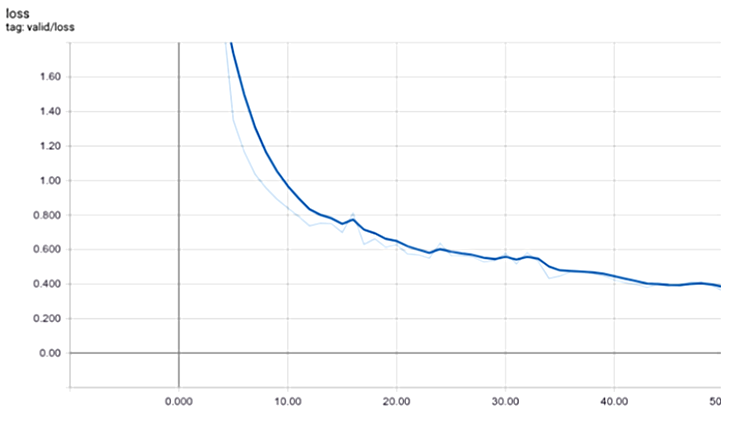

<b><span style="color:green">Визуализация</span></b> — полезный инструмент для отслеживания проблем в процессе обучения. Например, если график ошибки на валидации становится выше, чем график ошибки на обучении, то можно сказать, что модель переобучилась.  

В дальнейшем для визуализации вы можете использовать такие инструменты, как <b><span style="color:green">TensorBoard</span></b> от Google. Это бесплатный инструмент, позволяющий в реальном времени смотреть на метрики обучения, показывать графики ошибок. С его помощью вы сможете сравнивать графики по разным моделям, чтобы получить представление о том, какая модель лучше или хуже справилась, и какие ошибки возникли на пути. 

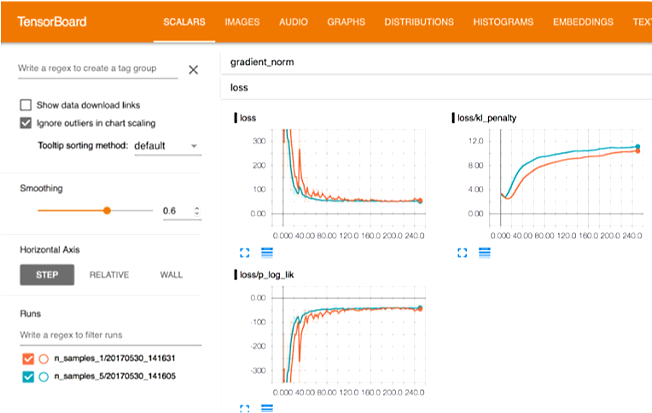

[К содержанию](#0)